In [41]:
%%capture

import warnings
warnings.filterwarnings('ignore')

# External libraries
import pandas as pd
import nltk
from nltk.corpus import wordnet
import re
import string
import random
import numpy as np
import importlib

# My Files
import transition_matrix as tm
import caption

# Ensure files are latest version
importlib.reload(tm)
importlib.reload(caption)


# nltk downloads
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


In [42]:
img_file = "./images/woman.jpeg"

In [43]:
cmudict = nltk.corpus.cmudict
phoneme_dict = dict(cmudict.entries())

In [44]:

"""
Credit: hauntsaninja @ https://datascience.stackexchange.com/questions/23376/how-to-get-the-number-of-syllables-in-a-word
""" 

VOWEL_RUNS = re.compile("[aeiouy]+", flags=re.I)
EXCEPTIONS = re.compile(
    # fixes trailing e issues:
    # smite, scared
    "[^aeiou]e[sd]?$|"
    # fixes adverbs:
    # nicely
    + "[^e]ely$",
    flags=re.I
)
ADDITIONAL = re.compile(
    # fixes incorrect subtractions from exceptions:
    # smile, scarred, raises, fated
    "[^aeioulr][lr]e[sd]?$|[csgz]es$|[td]ed$|"
    # fixes miscellaneous issues:
    # flying, piano, video, prism, fire, evaluate
    + ".y[aeiou]|ia(?!n$)|eo|ism$|[^aeiou]ire$|[^gq]ua",
    flags=re.I
)

def count_syllables_custom(word):
    vowel_runs = len(VOWEL_RUNS.findall(word))
    exceptions = len(EXCEPTIONS.findall(word))
    additional = len(ADDITIONAL.findall(word))
    return max(1, vowel_runs - exceptions + additional)

# Count syllables in word using nltk with custom fallback (courtesy @hautsaninja on StackExchange)

def count_syllables(word):
    if word in phoneme_dict:   
        return len([ph for ph in phoneme_dict[word] if ph.strip(string.ascii_letters)])
    elif not word.isalpha():
        return 0
    else:
        res = count_syllables_custom(word)
        return res

In [45]:
sentences, scores = caption.get_caption(img_file)
scores = [float(s) for s in scores]

In [46]:
sentences_and_scores = sorted(zip(scores, sentences))[::-1]
maxProb = 0.9
discount = 0.7
prob = maxProb

words = []
for _, s in sentences_and_scores:
    for w in s:
        if w in ["<start>", "<end>"]:
            continue
        if random.uniform(0,1) >= prob:
            words.append(w)
    prob *= discount

In [47]:
text = nltk.word_tokenize(" ".join(words))
tagged_text = nltk.pos_tag(text)

# https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk list of tag meanings
acceptable = ['NN', 'JJ', 'JJR', 'JJS' , 'NNS', 'PRP', 'RB', 'RBR', 'RBS', 'VB', 'RP', 'VBD', 'VBG', 'VBN', 'VBP']

#acceptable_words = [w if t in acceptable else None for w, t in tagged_text]
acceptable_words = list(filter(lambda c: c[1]  in acceptable, tagged_text))
acceptable_words = {w for w, _ in acceptable_words}

In [48]:
num_words = min(3, len(acceptable_words) - 1)
words = random.sample(range(0, len(acceptable_words)), num_words)
final_words = np.array(list(acceptable_words))
final_words = list(final_words[words])
final_words

['tree', 'park', 'forest']

# Generate Line One

In [ ]:
def get_first_line_start(word, start_symbol = "startlinehere"):
    starts = []
    PoetryMatrix.SparseMatrix.items()

In [49]:
def generate_candidate_lines(start_word, end_words, max_paths = [5, 10, 15, 20, 25], random_start = True):
    
    if random_start:
        starts = []
        for k,_ in PoetryMatrix.SparseMatrix.items():
            if start_word in k.split(',')[0]:
                starts.append(k)
        idx = random.randint(0, len(starts) - 1)
        starts[idx]
    else:
        idx = 0
        starts = [start_word]

    paths = []
    for max_path in max_paths:
        try:
            path, _ = tm.find_most_probable_path(PoetryMatrix.SparseMatrix, starts[idx], end_words, max_path = max_path, prohibited=[])
            tmp = []
            if "," in path[0]:
                w1, w2 = path[0].split(",")
            path = [w1, w2, *path[1:]]
            for w in path:
                if w not in ["endlinehere", "startlinehere", "lineendhere"]:
                    tmp.append(w)
            if tmp not in paths:
                paths.append(tmp)
        except:
            continue
    return paths


In [50]:


def fix_line(input_path, desired_syllables, no_words, end_symbols, matrix, prev = ["startlinehere", "endlinehere"]):
    
    """
    # Check if no path found, and choose random path
    if type(input_path[0]) is not str:
        new_sample = random.randint(0, len(input_path))
        path = input_path[new_sample]['nodes']
    else:
        path = input_path
    """
    path = input_path
    sentence = path
    
    """
    # Remove unwanted words (i.e. conditioned input or special symbols)
    for word in no_words:
        try:
            sentence.remove(word)
        except:
            continue
    """
    
    next_line = []

    sentence = []
    
    for w in path:
        if w not in ["endlinehere", "startlinehere", "lineendhere"]:
            sentence.append(w)
    
    if len(sentence) > desired_syllables:
        print("Too many tokens. Bumping end to next line...")
        while len(sentence) > desired_syllables:
            next_line = [sentence[-1]] + next_line
            sentence = sentence[:-1]


    line_syllables = 0
    
    # Count syllables
    for word in sentence:
        line_syllables += count_syllables(word)
        
        
        
        
    if line_syllables > desired_syllables:
        print("TOO LONG: Bumping last words")
        while line_syllables > desired_syllables:
            first_w_s = count_syllables(sentence[-1])
            next_line = [sentence[-1]] + next_line
            sentence = sentence[:-1]
            line_syllables -= first_w_s
        
        
    
    # Add a word if there are only 0 or 1 words
    if len(sentence) == 0:
        print("Line size 0! Adding word...")
        next_word = matrix.next_word(prev[-2], prev[-1])
        while next_word in ["endlinehere", "startlinehere", "lineendhere"]:
            next_word = matrix.next_word(prev[-2], prev[-1])
        sentence.append(next_word)
        line_syllables += count_syllables(next_word) 
    if len(sentence) == 1:
        print("Line size 1! Adding word...")
        next_word = matrix.next_word(prev[-1],sentence[0])
        while next_word in ["endlinehere", "startlinehere", "lineendhere"]:
            next_word = matrix.next_word(prev[-2], prev[-1])
        sentence.append(next_word)
        line_syllables += count_syllables(next_word) 
        
        
    # Replace words with synonyms to increase syllables if necessary
    if line_syllables < desired_syllables:
        print("Increasing line size with synonyms...")
        difference = line_syllables - desired_syllables
        #print(sentence)
        for i in range(len(sentence) - 2):
            w = sentence[i]
            sc = count_syllables(w)
            wsyn = wordnet.synsets(w)
            replaced = False
            for syn in wsyn:
                if replaced == True:
                    break
                for l in syn.lemmas():
                    if not l.name().isalpha():
                        continue
                    synsc = count_syllables(l.name())
                    if synsc > sc:
                        print('replaceing {} with {}. {} -> {}'.format(sentence[i], l.name(), count_syllables(sentence[i]), count_syllables(l.name())))
                        sentence[i] = l.name()
                        print("{} --> {} - {} + {} = {}".format(line_syllables, line_syllables, sc, synsc, (line_syllables - sc) + synsc))
                        line_syllables = (line_syllables - sc) + synsc
                        if line_syllables == desired_syllables:
                            return sentence, [matrix.next_word(sentence[-2], sentence[-1])]
                        replaced = True
                        break
            if line_syllables == desired_syllables:
                break
        if line_syllables < desired_syllables:
            if len(sentence) == 0:
                next_word = matrix.next_word(path[0].split(",")[0],path[0].split(",")[1])
            elif len(sentence) == 1:
                next_word = matrix.next_word(path[0].split(",")[1],path[1])
            else:
                next_word = matrix.next_word(sentence[-2],sentence[-1])
            sentence.append(next_word)
            line_syllables += count_syllables(next_word)
        

    # Add words to increase syllables if necessary        TODO: is this unused now??
    if line_syllables < desired_syllables:
        print("Increasing line size by adding words...")
    while line_syllables < desired_syllables:
        if len(sentence) == 0:
            next_word = matrix.next_word(path[0].split(",")[0],path[0].split(",")[1])
        elif len(sentence) == 1:
            next_word = matrix.next_word(path[0].split(",")[1],path[1])
        else:
            next_word = matrix.next_word(sentence[-2],sentence[-1])
        if next_word not in ["endlinehere", "startlinehere", "lineendhere"]:
            sentence.append(next_word)
            line_syllables += count_syllables(next_word)
        #print(sentence)
        
    # Replace words with synonyms to decrease syllables if necessary
    if line_syllables > desired_syllables:
        print("Decreasing line size with synonyms...")
        difference = line_syllables - desired_syllables
        for i in range(len(sentence)):
            w = sentence[i]
            sc = count_syllables(w)
            if sc > 1:
                wsyn = wordnet.synsets(w)
                replaced = False
                for syn in wsyn:
                    if replaced == True:
                        break
                    for l in syn.lemmas():
                        if not l.name().isalpha():
                            continue
                        synsc = count_syllables(l.name())
                        if synsc < sc:
                            print('replaceing {} with {}. {} -> {}'.format(sentence[i], l.name(), count_syllables(sentence[i]), count_syllables(l.name())))
                            sentence[i] = l.name()
                            print("{} --> {} - {} + {} = {}".format(line_syllables, line_syllables, sc, synsc, (line_syllables - sc) + synsc))
                            line_syllables = (line_syllables - sc) + synsc
                            if line_syllables == desired_syllables:
                                return sentence, [matrix.next_word(sentence[-2], sentence[-1])]
                            replaced = True
                            break
    
    
    attempts = 1000
    # Add words to increase syllables if necessary        TODO: is this unused now??
    if line_syllables < desired_syllables:
        print("Increasing line size by adding words...")
    while line_syllables < desired_syllables and attempts > 0:
        if len(sentence) == 0:
            next_word = matrix.next_word(path[0].split(",")[0],path[0].split(",")[1])
        elif len(sentence) == 1:
            next_word = matrix.next_word(path[0].split(",")[1],path[1])
        else:
            next_word = matrix.next_word(sentence[-2],sentence[-1])
        if next_word not in ["endlinehere", "startlinehere", "lineendhere"]:
            sc = count_syllables(next_word)
            if line_syllables + sc <= desired_syllables:
                sentence.append(next_word)
                line_syllables += sc
        attempts -= 1
        
        
    
    if line_syllables > desired_syllables:
        print("TOO LONG: Bumping last words")
        while line_syllables > desired_syllables:
            first_w_s = count_syllables(sentence[-1])
            next_line = [sentence[-1]] + next_line
            sentence = sentence[:-1]
            line_syllables -= first_w_s
            
            
    
    return sentence, next_line

In [51]:
start_symbols = ("endlinehere", "startlinehere")
poem_file = "./data/poems_selected_start_end_punc_breaks.txt"
prohibited = [*start_symbols]
line_length = 10 # syllables
end_symbols = [*final_words] # TODO add all words, add synonyms from word2vec to solve no path found

PoetryMatrix = tm.get_matrix(poem_file)

Processing ./data/poems_selected_start_end_punc_breaks.txt


In [52]:
candidate_lines_1 = generate_candidate_lines(end_symbols[0], end_symbols[1:])

In [53]:
candidate_lines_1

[['streets', 'but', 'the', 'little', 'park'],
 ['streets', 'but', 'the', 'park']]

In [54]:
line_one, next_line = fix_line(candidate_lines_1[0], 5, candidate_lines_1[0][0], [], PoetryMatrix)
print(line_one)

TOO LONG: Bumping last words
['streets', 'but', 'the', 'little']


In [18]:
line_one = ['woman', 'scrubs', 'the', 'smell']
next_line = ['of',
  'rain',
  'noticed',
  'by',
  'night',
  'at',
  'jung',
  'yang',
  'i',
  'was',
  'sitting']
if next_line:
    candidate_lines_2 = generate_candidate_lines(next_line[0], end_symbols[2:])
    print(candidate_lines_2)
    if len(candidate_lines_2) < 1:
        candidate_lines_2.append(next_line)
    line_two, next_line = fix_line(candidate_lines_2[0],
                                   7,
                                   candidate_lines_2[0][0],
                                   [],
                                   PoetryMatrix,
                                   prev = line_one[-2:])
else:
    candidate_lines_2 = generate_candidate_lines(end_symbols[2:], ["endlinehere", "lineendhere"])
    line_two, next_line = fix_line(candidate_lines_2[0], 7, candidate_lines_2[0][0], [], PoetryMatrix, prev = line_one[-2:])
    
    

[]
Too many tokens. Bumping end to next line...
TOO LONG: Bumping last words


IndexError: list index out of range

In [31]:
if next_line:
    candidate_lines_3 = generate_candidate_lines(next_line[0], ["endlinehere", "lineendhere", *end_symbols[3:]])
    line_three, next_line = fix_line(candidate_lines_3[0], 5, candidate_lines_3[0][0], [], PoetryMatrix, prev = line_two[-2:])
else:
    candidate_lines_3 = generate_candidate_lines(end_symbols[2], ["endlinehere", "lineendhere", *end_symbols[3:]])
    line_three, next_line = fix_line(candidate_lines_3[0], 5, candidate_lines_3[0][0], [], PoetryMatrix, prev = line_two[-2:])

Increasing line size with synonyms...


In [32]:
print(candidate_lines_3)
line_three, next_line = fix_line(candidate_lines_3[0], 5, candidate_lines_3[0][0], [], PoetryMatrix, prev = line_two[-2:])
print(line_three)
print(next_line)

[['jung', 'yang', '.']]
Increasing line size with synonyms...
['jung', 'yang', '.', 'lineendhere']
[]


In [33]:
print(line_one)
print(line_two)
print(line_three)

['woman', 'scrubs', 'the', 'smell']
['of', 'rain', 'noticed', 'by', 'night', 'at']
['jung', 'yang', '.', 'lineendhere']


In [34]:
from gingerit.gingerit import GingerIt

poem = ""

lines = [line_one, line_two, line_three]
for line in lines:
    text = " ".join(line)
    result = GingerIt().parse(text)['result']
    poem += result + "\n"

print(poem)

#poem += result['result'] + "\n"

woman scrubs the smell
of rain noticed by night at
Jung Yang. Lineendhere



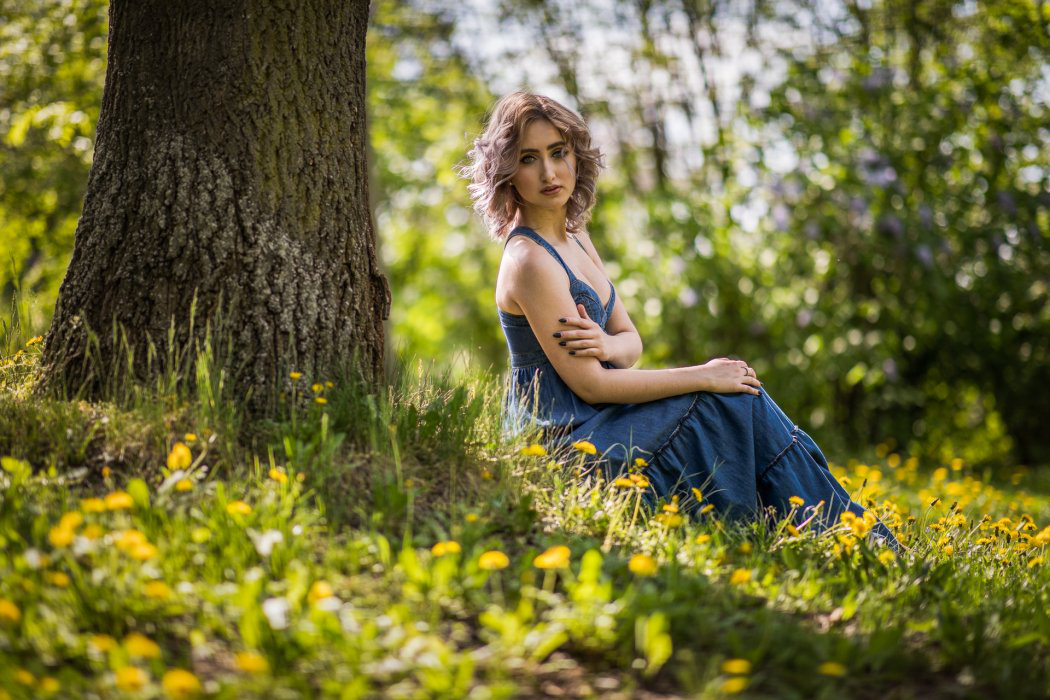

woman scrubs the smell
of rain noticed by night at
jung yang . lineendhere


In [35]:
from IPython.display import display
from PIL import Image
display(Image.open(img_file))
print(" ".join(line_one))
print(" ".join(line_two))
print(" ".join(line_three))

In [ ]:
len(PoetryMatrix.SparseMatrix)
count = 0
for k, v in PoetryMatrix.SparseMatrix.items():
    count += len(v)
count

In [ ]:
for s, l in sentences_and_scores:
    print("{}: {}".format(s, " ".join(l)))